## Load modules
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)  
[#Link-with-orography?](#Link-with-orography?)  

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 232 GB / percent used: 7.6 %


## Load model data

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
var = 'snc'
if var in ['tas', 'pr']:
    table = 'Amon'
elif var in ['snc']:
    table = 'LImon'
    
var_label = 'Snow cover extent [%]'
var_label_trends = 'Snow cover extent trends [%/dec]'
var_label_bias = 'Snow cover bias [%]'
cmap='viridis'
levels=plot.arange(0,100,10)

# Load ensemble mean
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)  
[#Link-with-orography?](#Link-with-orography?) 

In [3]:
realization = 'ens'
# Load historical ens
experiment='historical'
da_historical = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
)

## Load obs

#### NOAA Climate Data Record (CDR) of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1
https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756

##### Test davos ou lapaz colormaps (with update)
ex: https://climate.rutgers.edu/snowcover/chart_vis.php?ui_year=2020&ui_month=1&ui_set=1

In [4]:
obs_longname = 'NOAA Climate Data Record (CDR) Version 1'
obs_name = 'NOAA CDR'

In [5]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
ds_rutger

<xarray.Dataset>
Dimensions:               (cols: 88, rows: 88, time: 1774)
Coordinates:
  * time                  (time) datetime64[ns] 1981-01-05 ... 2014-12-29
    snow_cover_threshold  float32 ...
    latitude              (rows, cols) float64 ...
    longitude             (rows, cols) float64 ...
Dimensions without coordinates: cols, rows
Data variables:
    coord_system          |S1 ...
    land                  (rows, cols) float32 ...
    area                  (rows, cols) float32 ...
    snow_cover_extent     (time, rows, cols) float32 ...
Attributes:
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, NOAA C...
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        nhsce_v01r01_19661004_20191202.nc
    naming_authority:          gov.noaa.ncdc
    metadata_link:             https://doi.org/10.7289/V5N014G9
    title:                     Climate Data Record (CDR) of Northern Hemisphe...
    product_version:           v01r01
    summary:                   The data record for the NH SCE CDR spans from ...
    keywords:                  EARTH SCIENCE > CRYOSPHERE > SNOW/ICE > SNOW C...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Ear...
    platform:                  ESSA, NOAA POES, SMS, DMSP, GOES, TIROS, METEO...
    sensor:                    VIDEO CAMERA, VISSR, VAS, VHRR, AVHRR, VISSR-G...
    cdm_data_type:             Grid
    cdr_program:               NOAA Climate Data Record Program for satellites
    cdr_variable:              snow_cover_extent
    source:                    NOAA NH Weekly SCE, NIC NH IMS SCE
    date_created:              2019-12-03T03:11:23Z
    institution:               Global Snow Lab, Center for Environmental Pred...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    geospatial_lat_min:        0.0
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    spatial_resolution:        Minimum cell area 10676.8 km^2, maximum cell a...
    time_coverage_start:       1966-10-04
    time_coverage_end:         2019-12-02
    license:                   No restrictions on access or use

##### Get the snc variable, keep only land data, convert to % and resample by months  
Resampling with xarray: http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html  
**Offset aliases**: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases  
Here we use: **MS**	month start frequency

In [6]:
# Get the snc variable, keep only land data and convert to %
with xr.set_options(keep_attrs=True):
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100
    
obs.attrs['units'] = '%'

# Rename lon and lat for the regrid
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna='False', keep_attrs=True)
obs

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'snow_cover_extent' (time: 408, rows: 88, cols: 88)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time                  (time) datetime64[ns] 1981-01-01 ... 2014-12-01
    snow_cover_threshold  float32 0.42
    lat                   (rows, cols) float64 0.6592 1.322 ... 1.322 0.6592
    lon                   (rows, cols) float64 145.0 144.3 ... -35.67 -35.0
Dimensions without coordinates: rows, cols
Attributes:
    long_name:      NOAA/NCDC Climate Data Record of snow cover extent
    standard_name:  surface_snow_binary_mask
    grid_mapping:   coord_system
    valid_range:    [0 1]
    flag_values:    [0 1]
    flag_meanings:  no_snow snow_covered
    units:          %

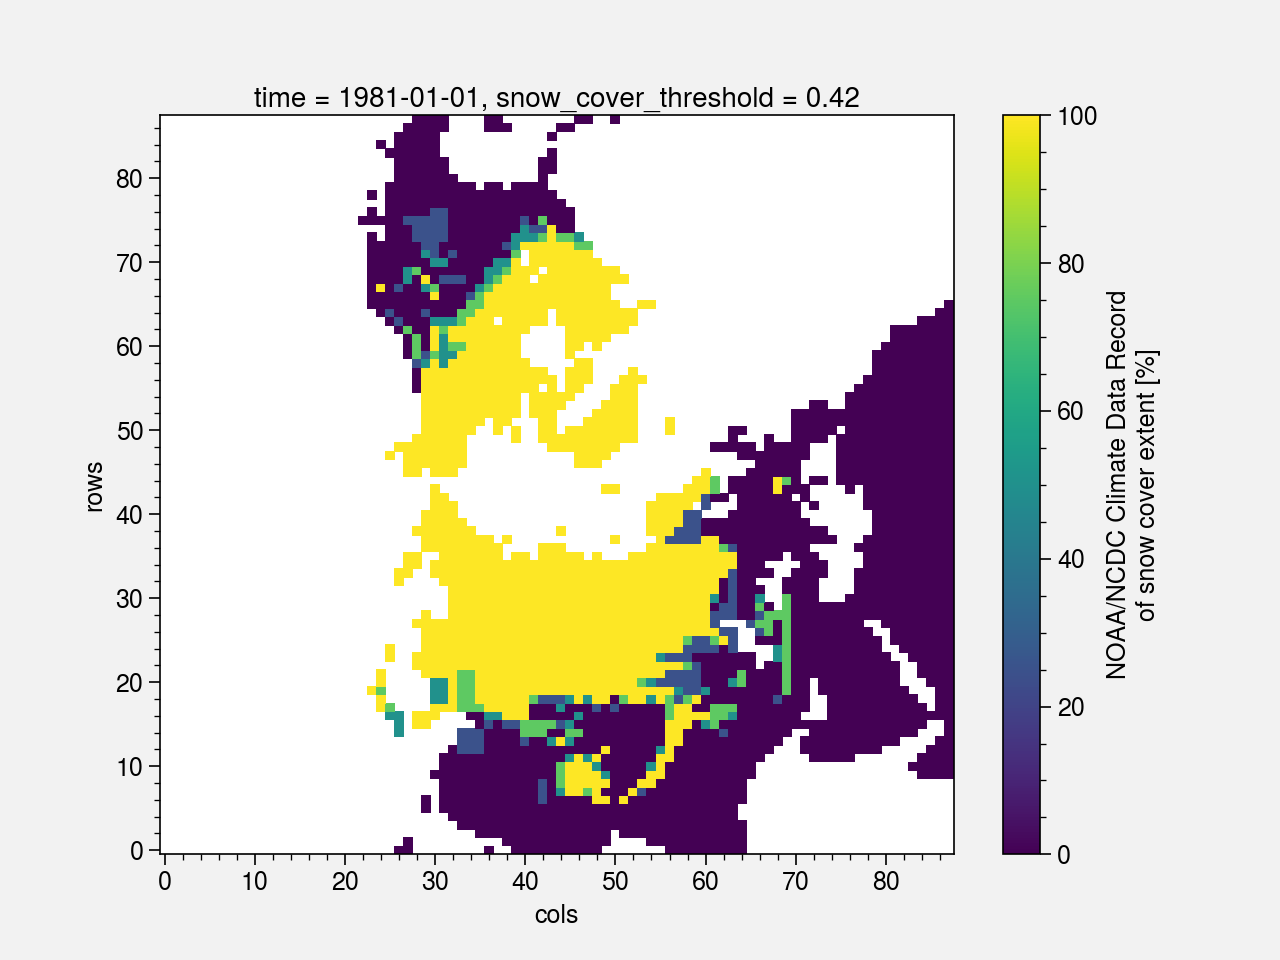

In [7]:
obs[0].plot()

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 
Value of cells in the new grid that are outside the old grid's domain #15 (https://github.com/JiaweiZhuang/xESMF/issues/15)

In [7]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

# Make the regrider
regridder_obs = xe.Regridder(obs, da_historical, 'bilinear', periodic=False)
regridder_obs = add_matrix_NaNs(regridder_obs)
print(regridder_obs)

# Regrid the data
obs_regrid = regridder_obs(obs)

Overwrite existing file: bilinear_88x88_143x144.nc 
 You can set reuse_weights=True to save computing time.


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_88x88_143x144.nc 
Reuse pre-computed weights? False 
Input grid shape:           (88, 88) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False


Text(0.5, 1.0, 'IPSL_CM6A_LR grid 143x144')

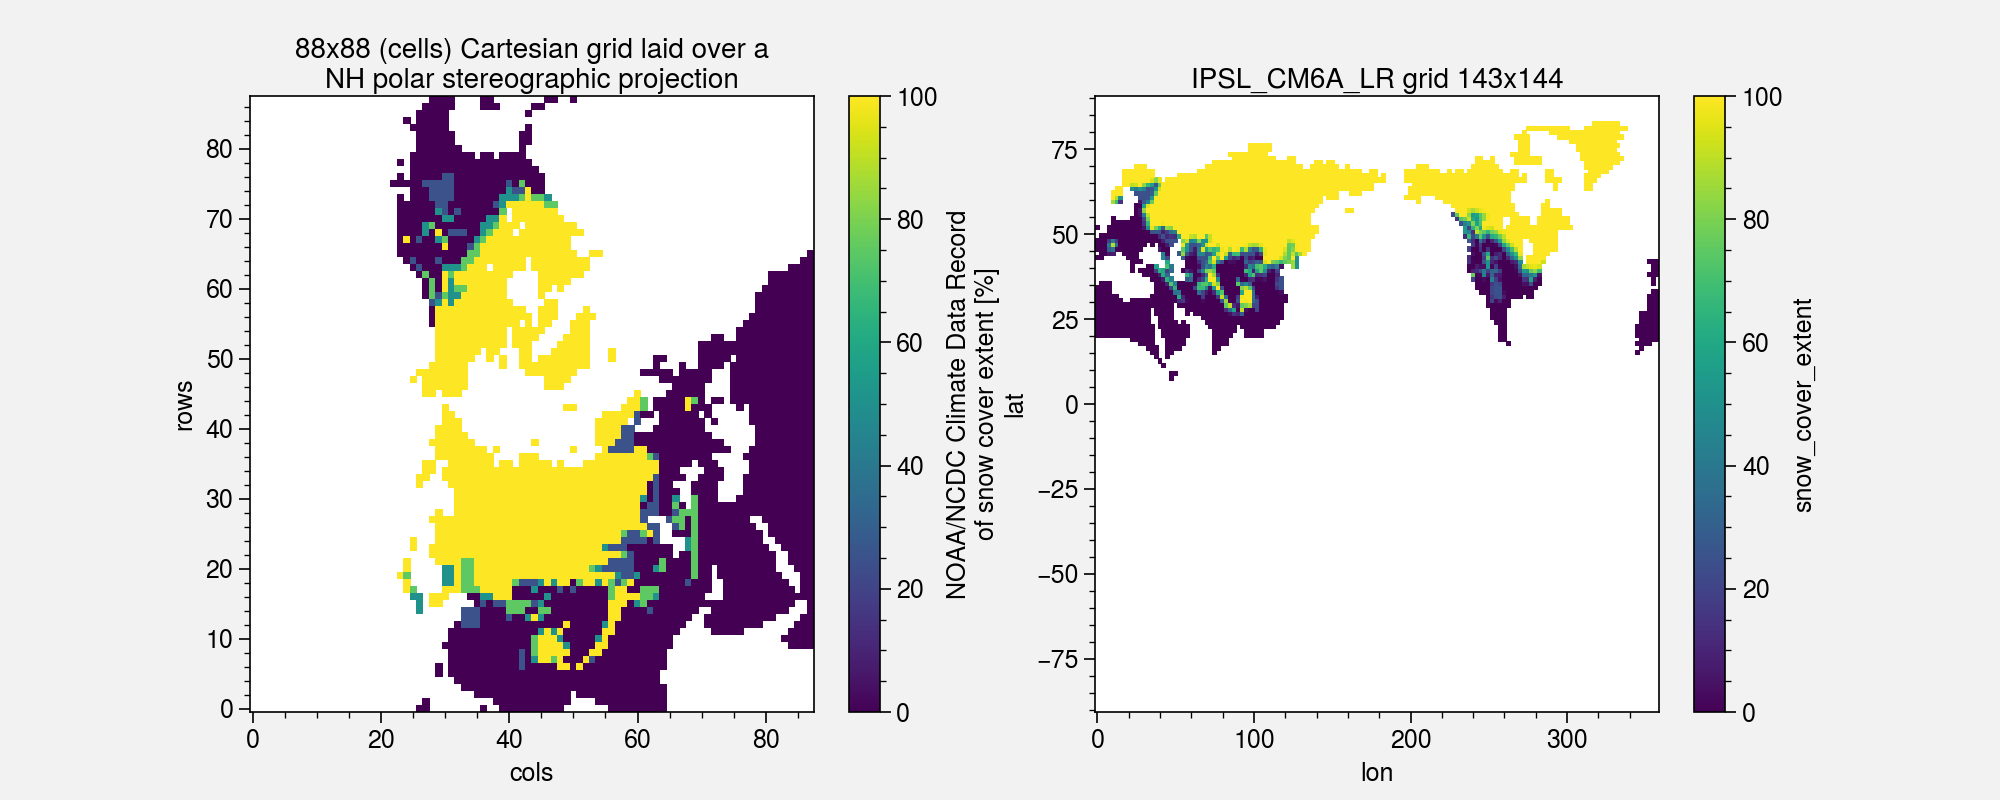

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(121)
obs[0].plot()
plt.title('88x88 (cells) Cartesian grid laid over a\nNH polar stereographic projection')
plt.subplot(122)
obs_regrid[0].plot()
plt.title('IPSL_CM6A_LR grid 143x144')

[#Regrid-HR](#Regrid-HR)

## Other snow dataset
- MERRA-2 (https://disc.gsfc.nasa.gov/datasets/M2TMNXLND_5.12.4/summary?keywords=%22MERRA-2%22%20FRSNO)

In [15]:
da = xr.open_dataarray(
    '/data/mlalande/MERRA-2/snc/MERRA2_400.tavgM_2d_lnd_Nx.198001-202002.nc4'
).sel(time=period).load()*100
da

<xarray.DataArray 'FRSNO' (time: 408, lat: 361, lon: 576)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * time     (time) datetime64[ns] 1981-01-01T00:30:00 ... 2014-12-01T00:30:00

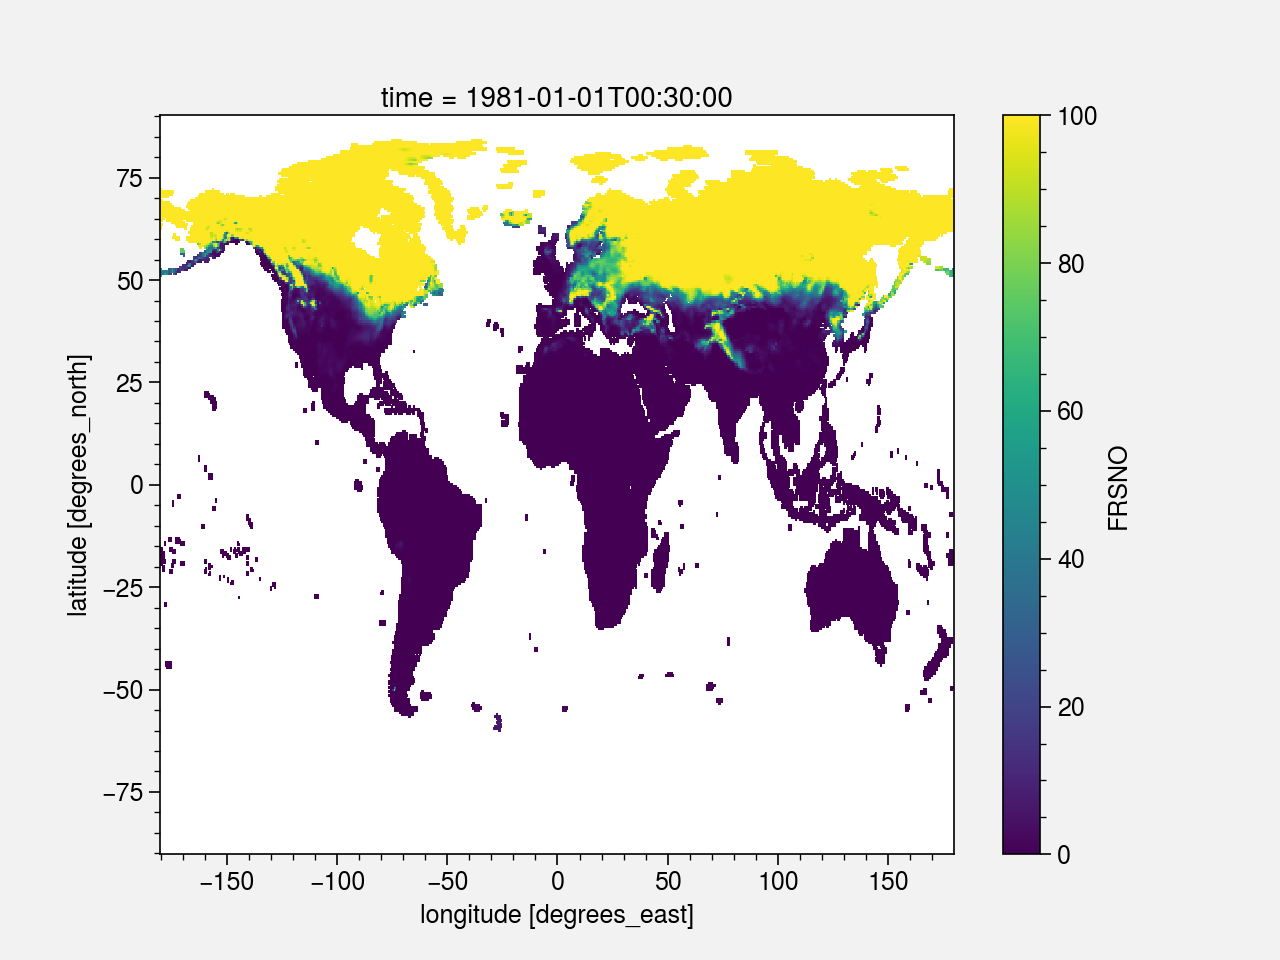

In [17]:
da[0].plot()

In [19]:
orso = da.sel(
    lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]), time=slice('2009','2013')
).groupby('time.month').mean('time')
orso

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'FRSNO' (month: 12, lat: 81, lon: 81)>
array([[[        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        [        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        [        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        ...,
        [ 89.7691   ,  87.307175 ,  82.44639  , ...,  62.609364 ,
          53.748634 ,  36.73753  ],
        [ 94.95343  ,  92.24272  ,  88.35437  , ...,  47.71164  ,
          64.6416   ,  70.50753  ],
        [ 98.796425 ,  97.72265  ,  94.94866  , ...,  71.06029  ,
          81.559654 ,  87.36056  ]],

       [[        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        [        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        [        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        ...,
        [ 98.44977  ,  95.90041  ,  92.93131  , ...,  64.30495  ,
          53.920685 ,  36.492546 ],
        [100.       ,  98.74239  ,  96.35063  , ...,  44.74212  ,
          63.917797 ,  71.140755 ],
        [100.       ,  99.90161  ,  99.06626  , ...,  72.729256 ,
          82.7084   ,  90.78392  ]],

       [[        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        [        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        [        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        ...,
        [ 66.82856  ,  64.01606  ,  58.52541  , ...,  46.11559  ,
          39.3234   ,  24.476841 ],
        [ 75.49495  ,  72.75593  ,  68.77959  , ...,  26.346851 ,
          49.69526  ,  63.116016 ],
        [ 85.74854  ,  81.691635 ,  77.54176  , ...,  49.88402  ,
          70.4284   ,  78.00809  ]],

       ...,

       [[        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        [        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        [        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        ...,
        [  1.6535982,   1.4087273,   1.1652353, ...,   8.134959 ,
           8.324922 ,   5.52957  ],
        [  1.4972522,   1.3351893,   1.2418981, ...,   6.3359437,
          10.403865 ,  13.802669 ],
        [  1.721736 ,   1.6248678,   1.534255 , ...,   8.826276 ,
          11.324276 ,  13.098409 ]],

       [[        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        [        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        [        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        ...,
        [ 10.929141 ,   9.643491 ,   7.7840524, ...,  23.621998 ,
          21.340755 ,  14.67366  ],
        [ 15.326487 ,  13.188215 ,  10.755813 , ...,  18.097275 ,
          26.122644 ,  30.940266 ],
        [ 25.607996 ,  20.03852  ,  17.249966 , ...,  26.472363 ,
          33.43808  ,  34.614452 ]],

       [[        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        [        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        [        nan,         nan,         nan, ...,   0.       ,
           0.       ,         nan],
        ...,
        [ 57.760048 ,  56.031982 ,  52.006092 , ...,  49.38284  ,
          42.82533  ,  30.257313 ],
        [ 66.20831  ,  63.70951  ,  59.83451  , ...,  38.13611  ,
          51.218727 ,  56.82544  ],
        [ 80.47496  ,  76.0188   ,  72.575424 , ...,  57.26069  ,
          67.00081  ,  68.40776  ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 60.0 60.62 61.25 61.88 ... 108.1 108.8 109.4 110.0
  * lat      (lat) float64 10.0 10.5 11.0 11.5 12.0 ... 48.0 4

Text(0.5, 1.0, 'ERA5 annual mean (2009-2013)')

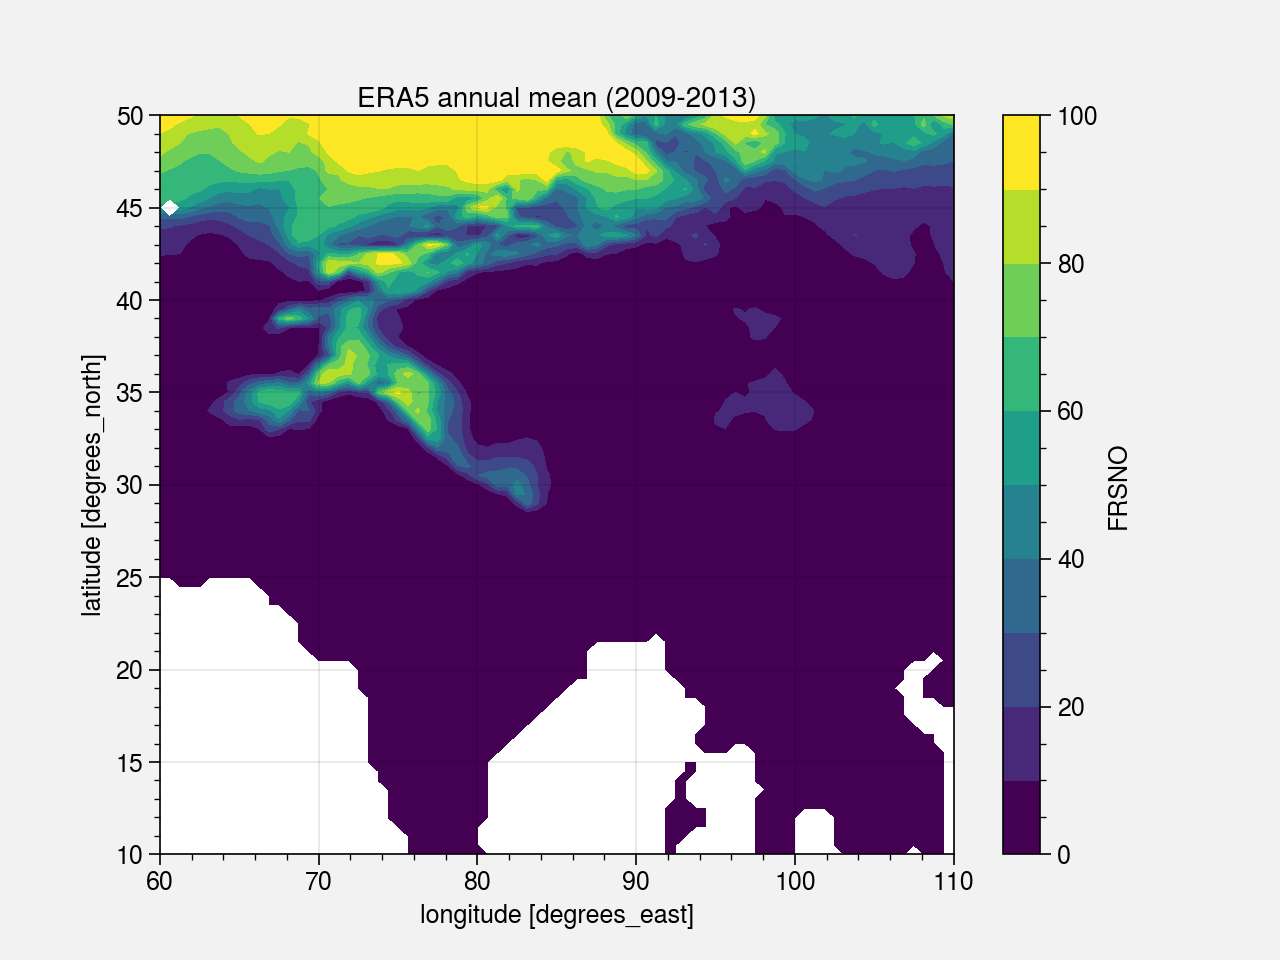

In [20]:
orso.sel(month=1).plot.contourf(levels=11)
plt.title('ERA5 annual mean (2009-2013)')
# plt.savefig('scf_ERA5_annual_mean_2009-2013.pdf')

In [21]:
# Make the regrider
regridder = xe.Regridder(da, da_historical, 'bilinear', periodic=True, reuse_weights=True)
regridder

Create weight file: bilinear_361x576_143x144_peri.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x576_143x144_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (361, 576) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [22]:
# Regrid the data
da_regrid = regridder(da)

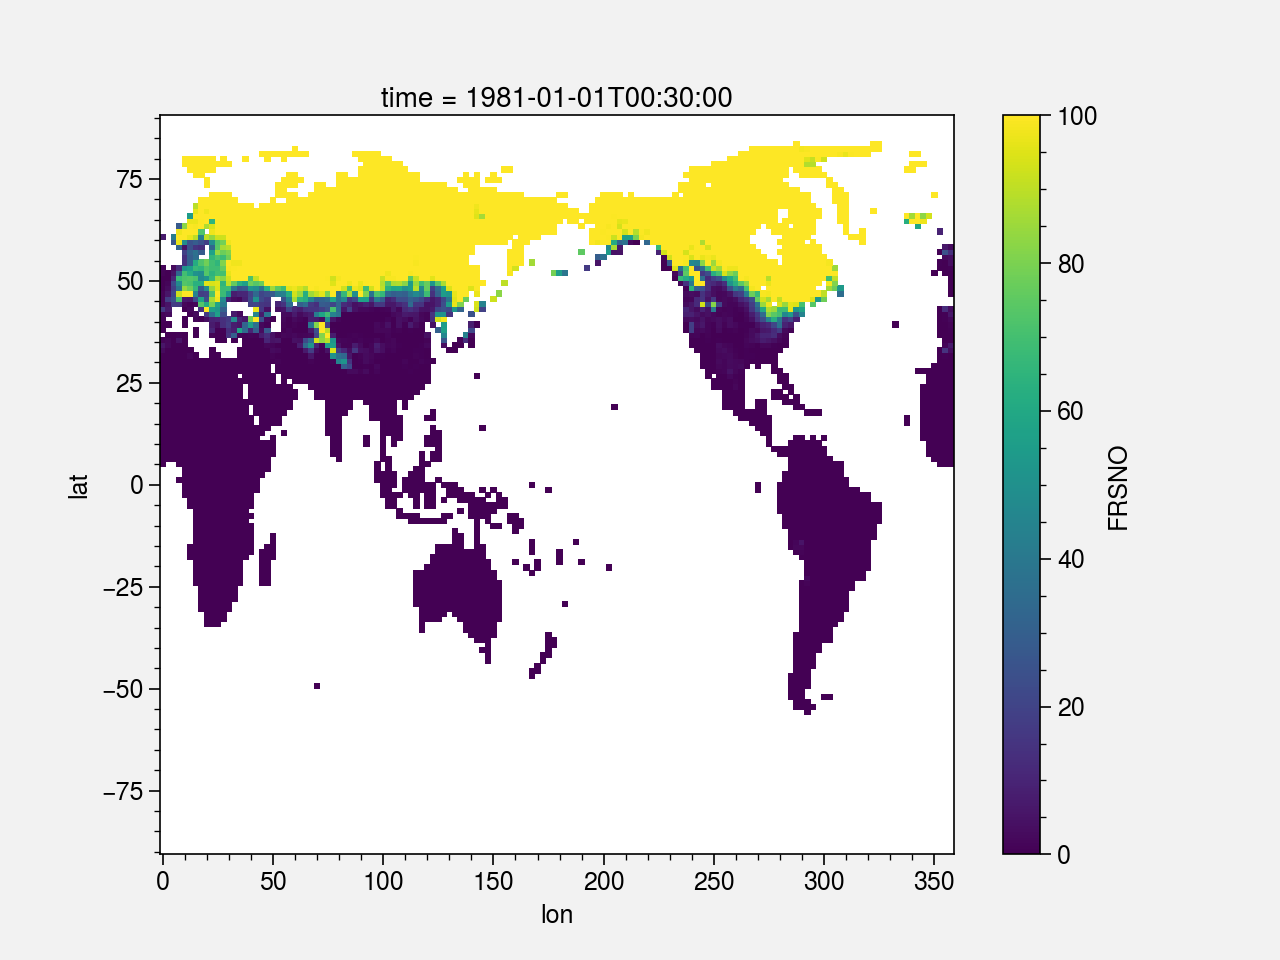

In [23]:
da_regrid[0].plot()

In [24]:
da_regrid_mon = da_regrid.groupby('time.month').mean('time').sel(
    lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])
)
da_regrid_mon

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'FRSNO' (month: 12, lat: 32, lon: 21)>
array([[[           nan,            nan,            nan, ...,
         0.00000000e+00,            nan,            nan],
        [           nan,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00,            nan],
        [           nan,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00,            nan],
        ...,
        [6.87784484e+01, 6.56217011e+01, 7.19013262e+01, ...,
         2.21548507e+01, 2.32428237e+01, 2.54550093e+01],
        [8.41993432e+01, 7.56076645e+01, 8.42266661e+01, ...,
         3.76725103e+01, 5.11856817e+01, 3.42978405e+01],
        [9.44904728e+01, 9.08836527e+01, 9.04874482e+01, ...,
         6.32104011e+01, 5.46893696e+01, 6.55081694e+01]],

       [[           nan,            nan,            nan, ...,
         0.00000000e+00,            nan,            nan],
        [           nan,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00,            nan],
        [           nan,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00,            nan],
        ...,
        [7.26592417e+01, 6.65984591e+01, 7.37581038e+01, ...,
         2.11456949e+01, 2.46027400e+01, 2.64615913e+01],
        [9.37092222e+01, 8.45952778e+01, 9.22696836e+01, ...,
         3.89175685e+01, 5.36128578e+01, 3.46494105e+01],
        [9.95692450e+01, 9.68850629e+01, 9.74811049e+01, ...,
         6.72891501e+01, 5.24049104e+01, 6.59579989e+01]],

       [[           nan,            nan,            nan, ...,
         0.00000000e+00,            nan,            nan],
        [           nan,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00,            nan],
        [           nan,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00,            nan],
        ...,
        [2.08847301e+01, 1.36983883e+01, 1.76670348e+01, ...,
         8.10192187e+00, 1.08258898e+01, 1.06696424e+01],
        [4.08263912e+01, 2.87565015e+01, 3.24024923e+01, ...,
         1.52957624e+01, 3.63329258e+01, 1.80993072e+01],
        [6.53648734e+01, 5.32031897e+01, 4.70508935e+01, ...,
         3.77807635e+01, 2.66403488e+01, 5.07989877e+01]],

       ...,

       [[           nan,            nan,            nan, ...,
         0.00000000e+00,            nan,            nan],
        [           nan,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00,            nan],
        [           nan,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00,            nan],
        ...,
        [1.87753889e-01, 9.73502681e-02, 2.15501910e-01, ...,
         1.69658792e+00, 1.57931938e+00, 1.60301795e+00],
        [4.34964526e-01, 2.39868509e-01, 3.84163790e-01, ...,
         2.91408585e+00, 5.91477970e+00, 3.62786919e+00],
        [8.48797648e-01, 4.76251812e-01, 5.89068566e-01, ...,
         5.03955551e+00, 5.66640376e+00, 1.04803552e+01]],

       [[           nan,            nan,            nan, ...,
         0.00000000e+00,            nan,            nan],
        [           nan,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00,            nan],
        [           nan,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00,            nan],
        ...,
        [6.09997238e+00, 4.40174639e+00, 5.13220477e+00, ...,
         6.98303231e+00, 7.54356074e+00, 7.83972862e+00],
        [1.07409555e+01, 6.75594021e+00, 9.03623939e+00, ...,
         1.24959610e+01, 2.02234674e+01, 1.21331498e+01],
        [1.62287597e+01, 1.18367187e+01, 1.14847097e+01, ...,
         2.35269053e+01, 2.07035003e+01, 2.85705260e+01]],

       [[           nan,            nan,            nan, ...,
         0.00000000e+00,            nan,            nan],
        [           nan,            nan,            nan, ...,
         0.00000000e+00, 0.00000000e+00,            nan],
        [      

#### Monthly mean

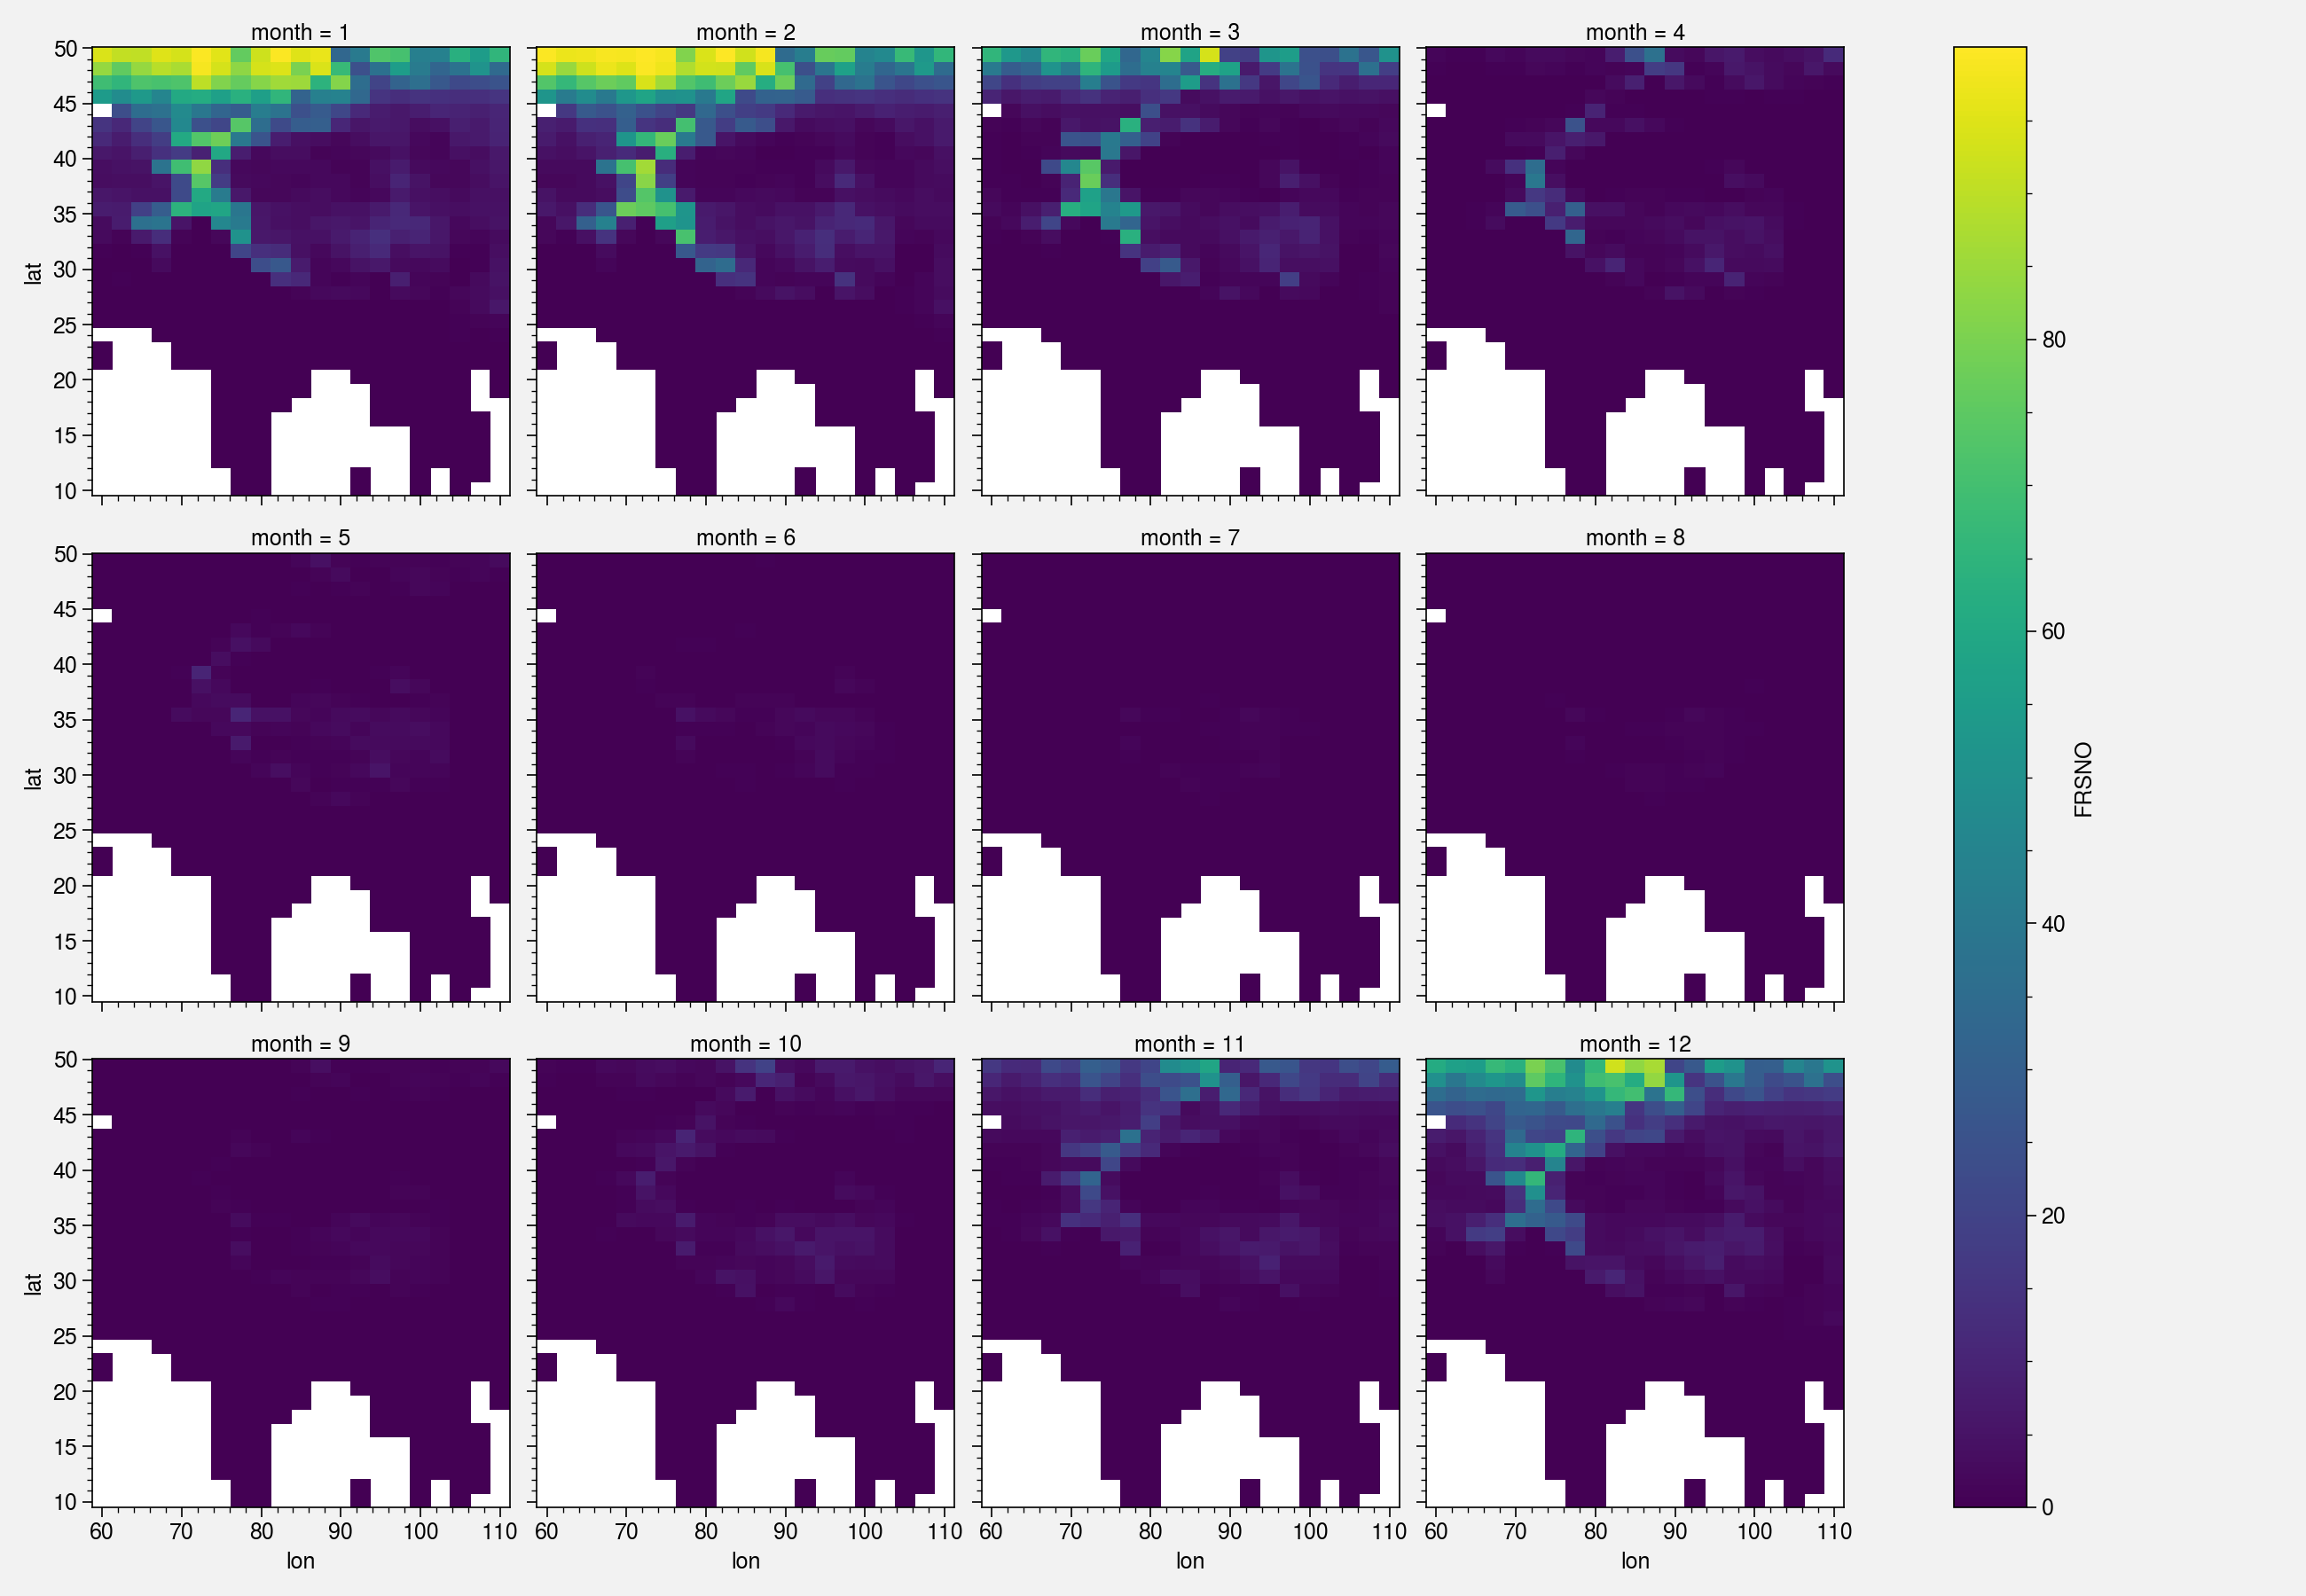

In [25]:
da_regrid_mon.plot(col='month', col_wrap=4, robust=False)

In [26]:
obs_mon = obs_regrid.groupby('time.month').mean('time').sel(
    lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])
)
obs_mon

<xarray.DataArray 'snow_cover_extent' (month: 12, lat: 32, lon: 21)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [9.05357804e+01, 9.42354777e+01, 9.50180349e+01, ...,
         9.58052997e+01, 9.91032245e+01, 9.90550884e+01],
        [9.66370322e+01, 9.78039480e+01, 9.83913729e+01, ...,
         9.90546673e+01, 9.97980191e+01, 9.95964000e+01],
        [9.95587603e+01, 9.96493616e+01, 9.97590857e+01, ...,
         9.96627832e+01, 1.00000000e+02, 9.99210896e+01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [9.25456095e+01, 9.47387287e+01, 9.48952201e+01, ...,
         9.11465398e+01, 9.58502593e+01, 9.55962486e+01],
        [9.94873165e+01, 9.95088338e+01, 9.96923991e+01, ...,
         9.75662112e+01, 9.84607164e+01, 9.61187703e+01],
        [9.99462111e+01, 1.00000000e+02, 1.00000000e+02, ...,
         9.90985270e+01, 9.92399890e+01, 9.83151769e+01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [6.07661717e+01, 5.78338351e+01, 5.97115186e+01, ...,
         4.96786298e+01, 4.89934161e+01, 5.71765516e+01],
        [8.05207755e+01, 7.64073552e+01, 8.13268279e+01, ...,
         6.81166607e+01, 7.70919183e+01, 7.21885201e+01],
        [9.17079630e+01, 8.99192262e+01, 9.09192688e+01, ...,
         7.89370599e+01, 8.57649978e+01, 8.46832292e+01]],

       ...,

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [2.69153659e-01, 6.62153870e-02, 6.56260140e-01, ...,
         1.05917802e+01, 8.71839099e+00, 7.51500019e+00],
        [1.13273813e+00, 6.96777498e-01, 1.02319020e+00, ...,
         1.00989219e+01, 1.30663929e+01, 1.39576677e+01],
        [2.95950497e+00, 1.82315218e+00, 1.89019024e+00, ...,
         7.17715544e+00, 8.51808053e+00, 9.28002127e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [1.44098764e+01, 1.36183685e+01, 1.91069296e+01, ...,
         5.54320645e+01, 3.82771176e+01, 4.46353830e+01],
        [2.31412229e+01, 2.10705603e+01, 2.87964718e+01, ...,
         6.21614834e+01, 5.81717525e+01, 5.69578811e+01],
        [3.71977228e+01, 3.30208770e+01, 3.81513753e+01, ...,
         5.98705631e+01, 6.27529050e+01, 6.29119518e+01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
   

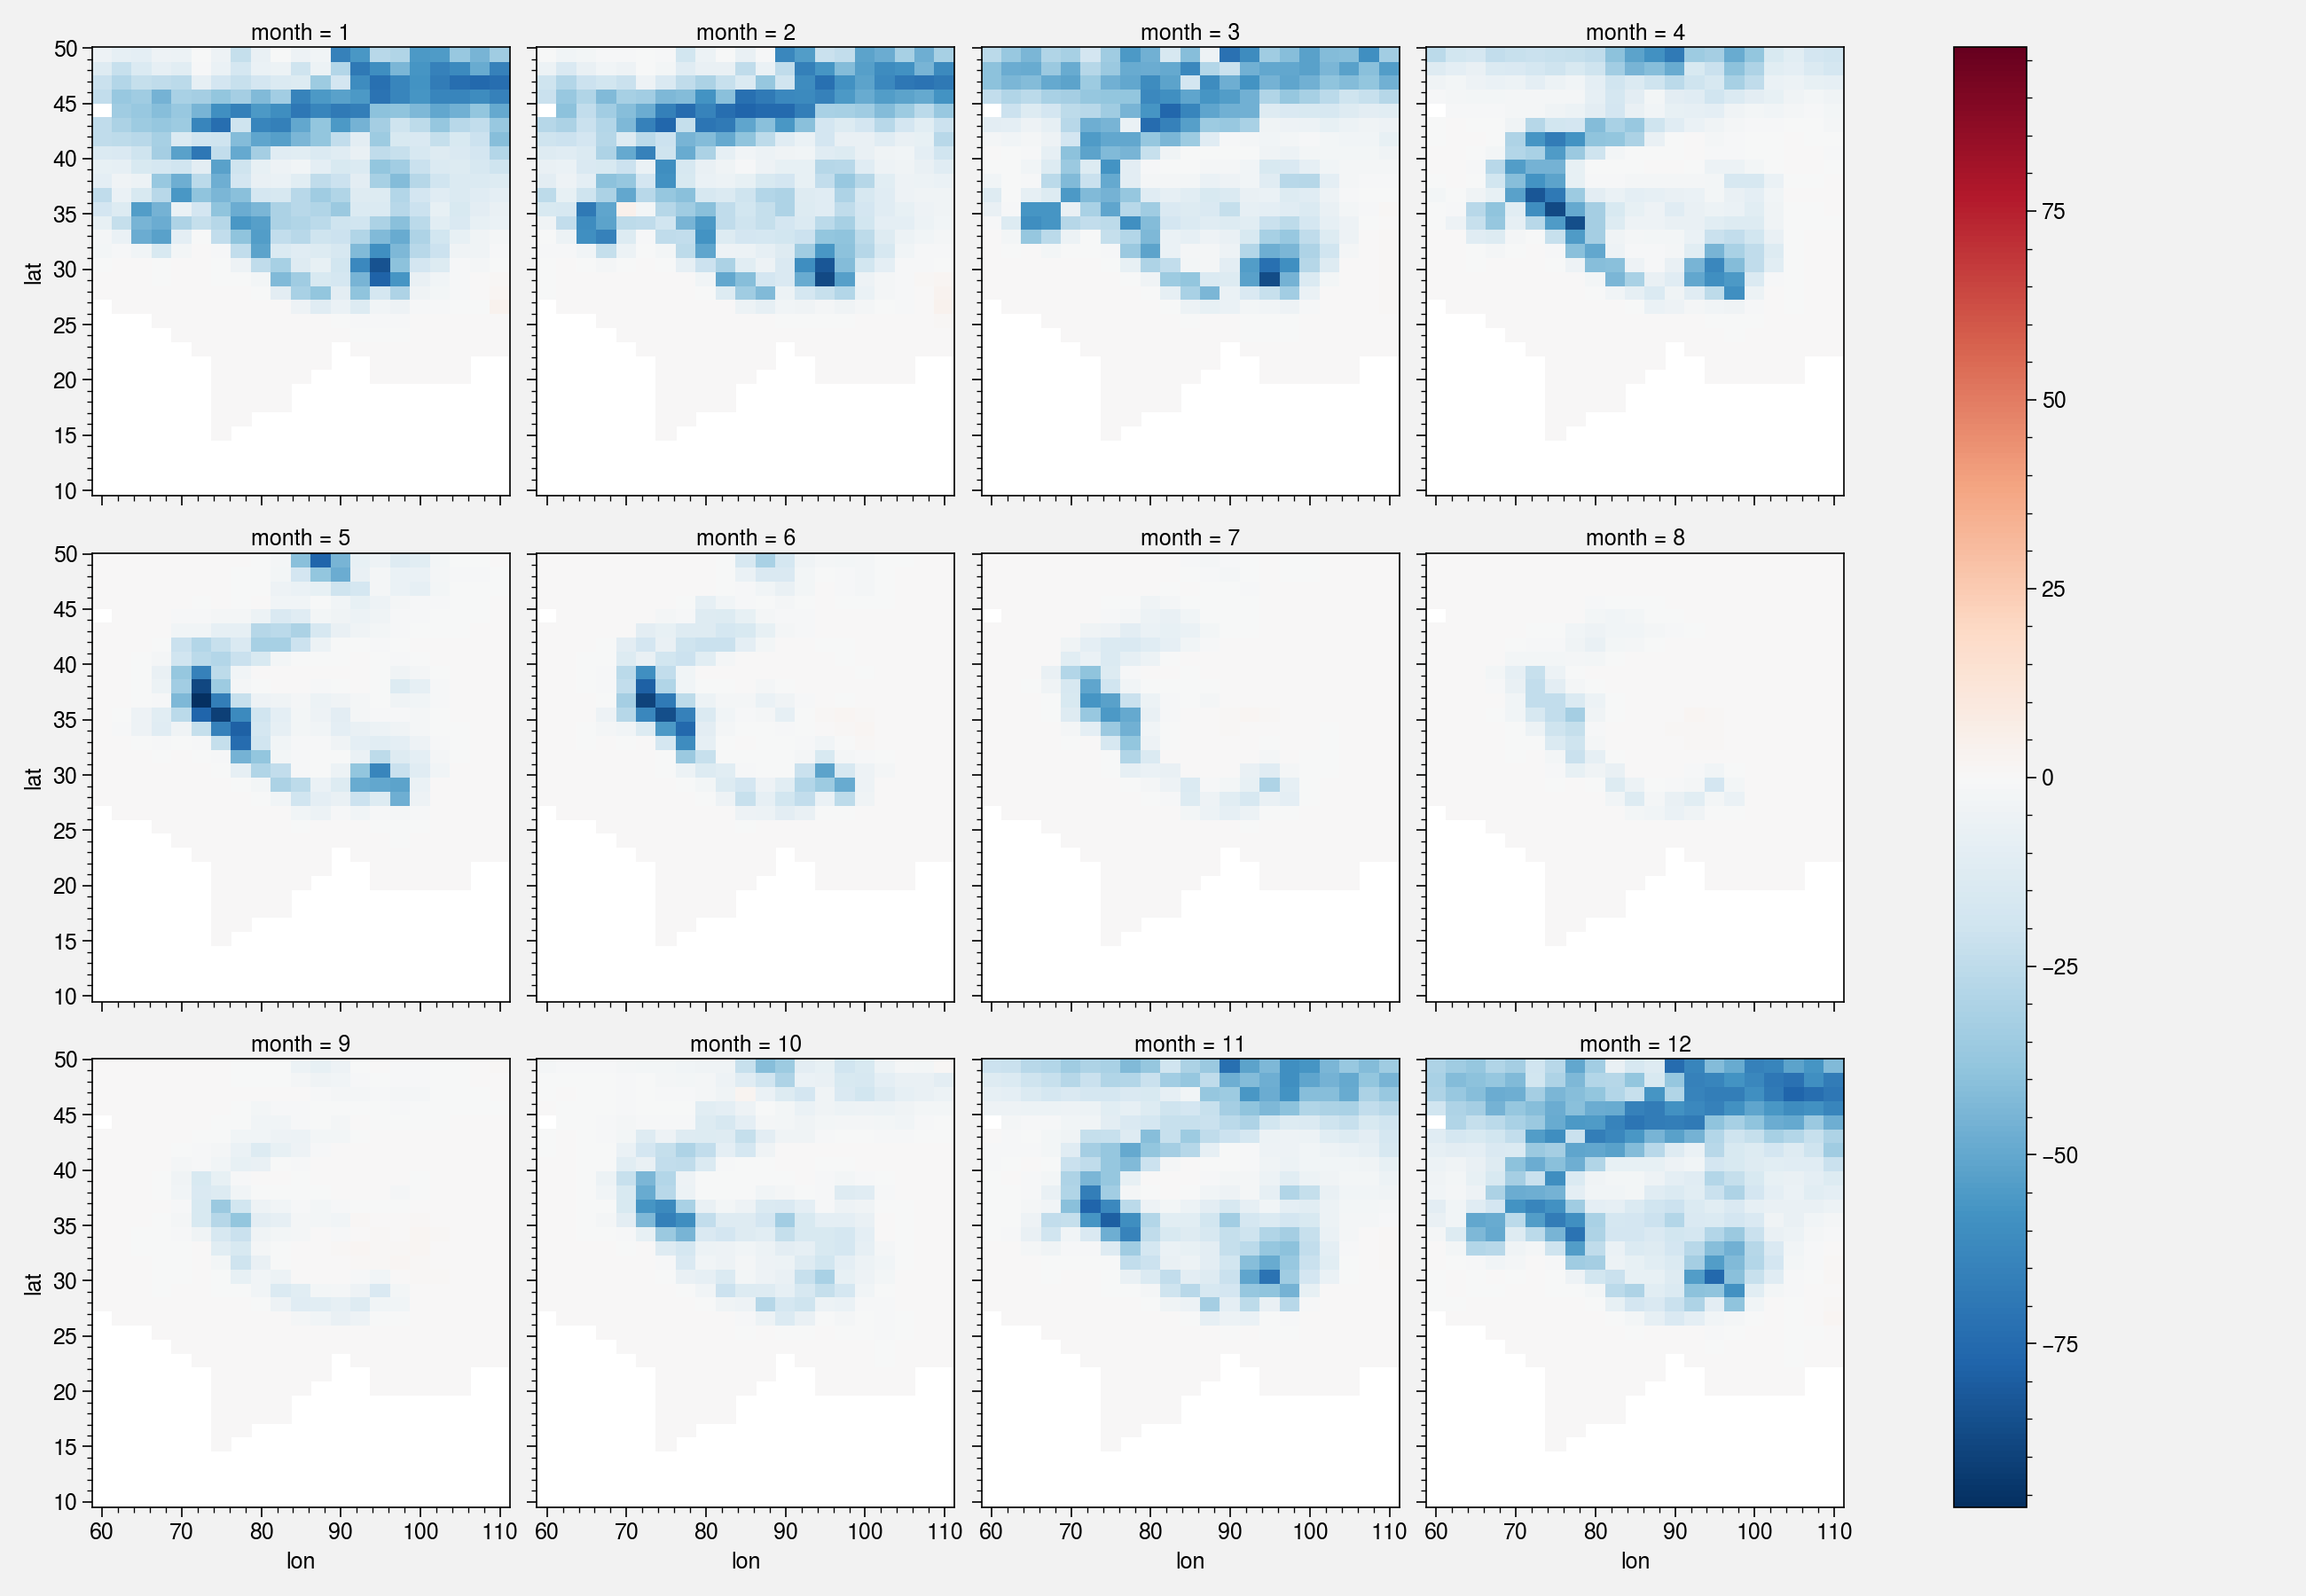

In [28]:
(da_regrid_mon-obs_mon).plot(col='month', col_wrap=4, robust=False)

In [29]:
bias = da_regrid_mon.mean('month')-obs_mon.mean('month')

In [30]:
bias.min()

<xarray.DataArray ()>
array(-58.59236469)
Coordinates:
    snow_cover_threshold  float32 0.42

In [31]:
bias.max()

<xarray.DataArray ()>
array(0.93816642)
Coordinates:
    snow_cover_threshold  float32 0.42

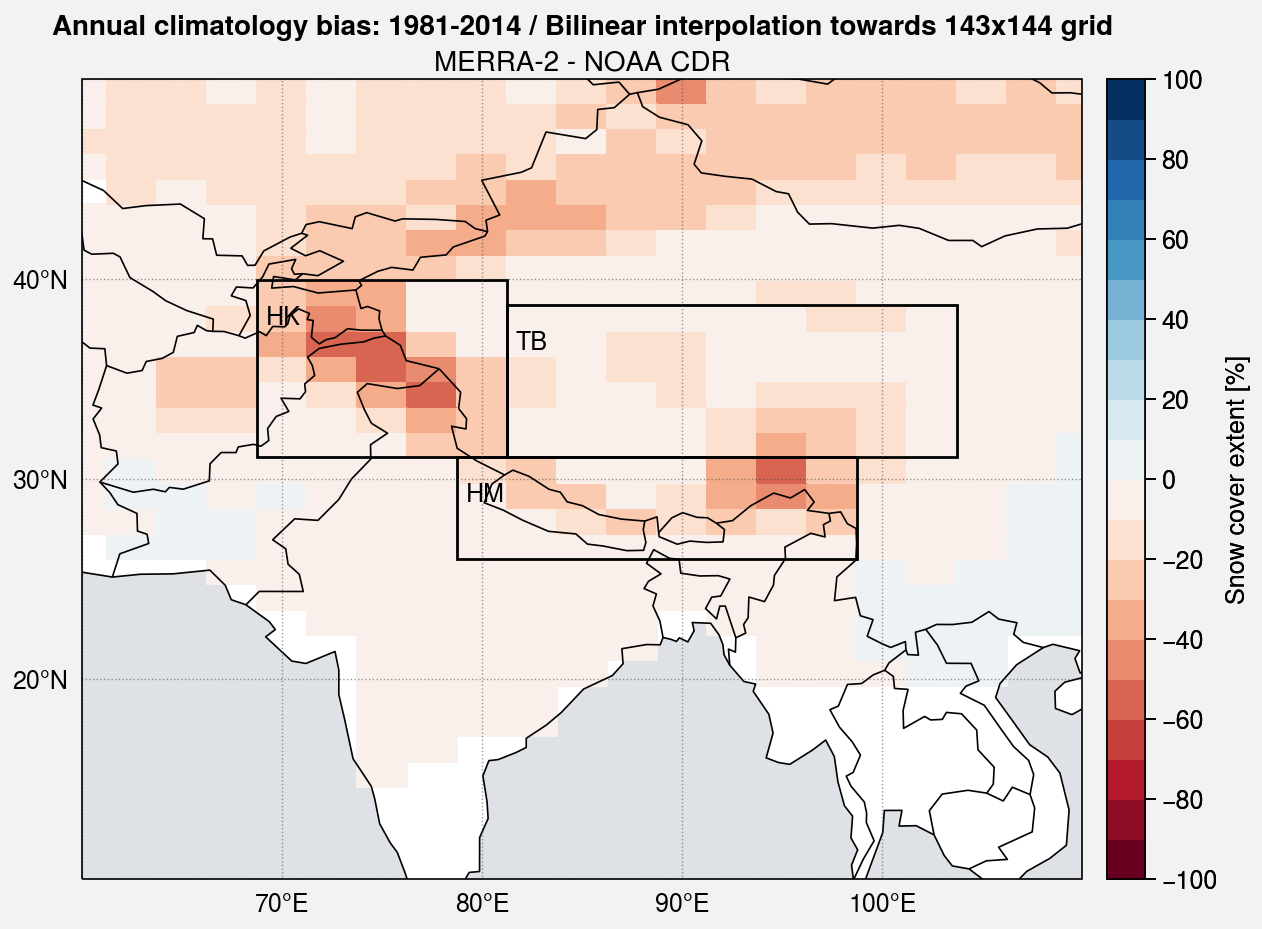

In [32]:
# Final plot

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, share=3, axwidth=5)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        bias, 
        cmap='RdBu', 
        levels=plot.arange(-100,100,10), 
#         extend='both',
#         norm='midpoint'
    )
    ax.format(title='MERRA-2 - NOAA CDR')

f.colorbar(m, label=var_label)

# Add boxes
for ax in axs:
    u.plot_zones_IPSL_CM6A_LR(ax)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology bias: 1981-2014 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'/'+var+'_MERRA_2-NOAA_CDR_bias.png')